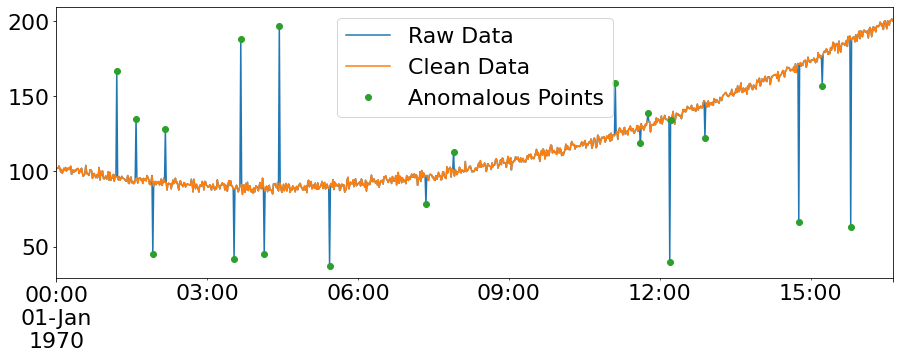

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
rng = np.random.default_rng(12345)
# Define index
nx = 1000
index = pd.date_range(start="1970", periods=nx, freq="1T")
# Define signal and noise
x = np.linspace(0, 10, nx)
signal =  2*x**2- 10* x + 2
noise = np.random.normal(loc=100, size=nx, scale=2)
y = noise + signal
# Add anomalies
anom_num = rng.integers(low=0, high=200, size=20)
anom_ids = rng.integers(low=0, high=nx, size=20)
y[anom_ids] = anom_num
is_anom = [True if item in anom_ids else False for item in range(nx)]
# Pandas DataFrame and plot
raw_data = pd.Series(y, index = index)
clean_data = raw_data[np.invert(is_anom)]
raw_data.plot(figsize=(15,5))
clean_data.plot()
raw_data[anom_ids].plot(style='o')
plt.legend(['Raw Data', 'Clean Data','Anomalous Points'])
plt.savefig('Toy_data_set.png', bbox_inches='tight', dpi=1000)
#plt.autoscale()
plt.rcParams.update({'font.size': 22})


In [14]:
poly_order = 2
x = (np.array(raw_data.index, dtype=np.int64) - raw_data.index[0].value) / 1e9
y = raw_data.to_numpy()
# Create a polynomial fit and apply the fit to data
coefs = np.polyfit(x, y, poly_order)
y_pred = np.polyval(coefs, x)

In [15]:
# Calculate hat matrix
X_mat = np.vstack((np.ones_like(x), x)).T
X_hat = X_mat @ np.linalg.inv(X_mat.T @ X_mat) @ X_mat.T
hat_diagonal = X_hat.diagonal()

In [22]:
from scipy.stats import t as student_dist


# Calculate degrees of freedom
n = len(y)
dof = n - 3  # Using p = 2 from paper
# Calculate standardised residuals 
res = y - y_pred
sse = np.sum(res ** 2)
t_res = res * np.sqrt(dof / (sse * (1 - hat_diagonal) - res))
# Return p values from Student distribution and calculate Bonferroni critical value
#p_vals = student_dist.pdf(t_res, df=dof)

In [48]:
bc

3.3148376892424216

In [49]:
t_res

array([-1.13298489e-01, -3.75634950e-02, -2.69894150e-02,  1.41541588e-01,
       -3.53880560e-03, -2.71355127e-01, -8.48226612e-02, -3.59656222e-01,
       -1.45333708e-01,  4.33366269e-02, -1.18754499e-01,  1.17282249e-01,
       -1.33078352e-01, -5.64646074e-03,  1.07450012e-01, -9.30548871e-04,
        1.22563195e-01,  2.72245218e-01, -3.21124017e-01,  3.69805591e-02,
       -1.92326511e-02, -1.28442105e-01,  3.36905056e-02, -3.40941294e-02,
        1.26142981e-01,  1.76404243e-01,  1.96752944e-01, -1.58144317e-01,
       -3.49520018e-02,  1.63128922e-01,  2.52686715e-01, -1.33842788e-01,
       -3.27896659e-01, -2.10611457e-01, -1.00711186e-01,  5.17981440e-01,
        2.43437728e-02, -1.31655534e-01, -7.65729536e-02, -1.90801342e-01,
        2.40053006e-01,  2.46461420e-01,  1.71104005e-01, -3.70135890e-01,
       -1.10920501e-02,  8.79986391e-03, -1.50603496e-01, -2.83329853e-01,
       -5.97762597e-02, -2.75926910e-01, -1.15663092e-02,  5.09221058e-01,
       -4.10348140e-01,  

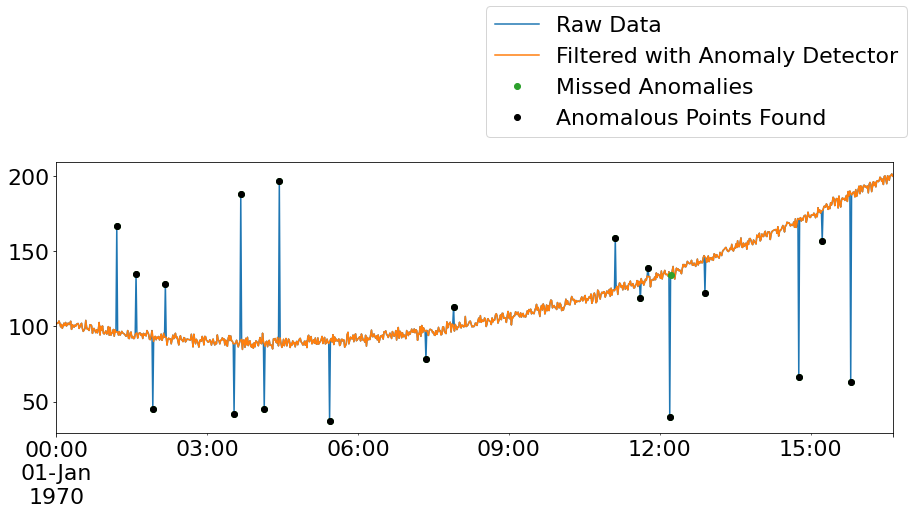

In [52]:
# Return filtered dataframe with the anomalies removed using BC value
alpha=0.05
bc = student_dist.ppf(1-alpha / (2 * n), df=dof)/6
mask = np.logical_and(t_res < bc, t_res > -bc)
# Plot anomalous and filtered data
ax=raw_data.plot(figsize=(15,5))

raw_data[mask].plot(ax=ax)
raw_data[anom_ids].plot(style='o')

raw_data[np.invert(mask)].plot(style='ok')
plt.legend(['Raw Data','Filtered with Anomaly Detector', 'Missed Anomalies', 'Anomalous Points Found'],bbox_to_anchor=(0.5, 1.05))
plt.rcParams.update({'font.size': 22})

#plt.savefig('results_1.png', bbox_inches='tight', dpi=1000)
#plt.autoscale()


In [59]:
len(raw_data[np.invert(mask)])

19

In [42]:
def anomaly_detector(raw_data):
    poly_order = 2
    x = (np.array(raw_data.index, dtype=np.int64) - raw_data.index[0].value) / 1e9
    y = raw_data.to_numpy()
    # Create a polynomial fit and apply the fit to data
    coefs = np.polyfit(x, y, poly_order)
    y_pred = np.polyval(coefs, x)
    
    # Calculate hat matrix
    X_mat = np.vstack((np.ones_like(x), x)).T
    X_hat = X_mat @ np.linalg.inv(X_mat.T @ X_mat) @ X_mat.T
    hat_diagonal = X_hat.diagonal()
    
    from scipy.stats import t as student_dist


    # Calculate degrees of freedom
    n = len(y)
    dof = n - 3  # Using p = 2 from paper
    # Calculate standardised residuals 
    res = y - y_pred
    sse = np.sum(res ** 2)
    t_res = res * np.sqrt(dof / (sse * (1 - hat_diagonal) - res))
    # Return p values from Student distribution and calculate Bonferroni critical value
    p_vals = student_dist.sf(t_res, df=dof)
    
    # Return filtered dataframe with the anomalies removed using BC value
    alpha=0.05
    bc = student_dist.sf(1 - alpha / (2 * n), df=dof)
    mask = np.logical_and(p_vals >= bc, p_vals <= (1 - bc))
    
    return mask
    

In [44]:
from cognite.client import CogniteClient
import os
import pandas as pd
# Instantiate CogniteClient
api_key = os.environ['PUBLIC_DATA_API_KEY']
client = CogniteClient(api_key=api_key, client_name='public-data-user')
# Retrieve Data from Cognite API#
df = client.datapoints.retrieve(external_id='pi:160696', start='200d-ago', end='now', granularity='1h', aggregates=['average']).to_pandas()
df = df['pi:160696|average']

/tmp/ipykernel_118030/745200335.py:6: UserWarning: Authenticated towards inferred project 'publicdata'. Pass project to the CogniteClient constructor or set the environment variable 'COGNITE_PROJECT' to suppress this warning.
  client = CogniteClient(api_key=api_key, client_name='public-data-user')


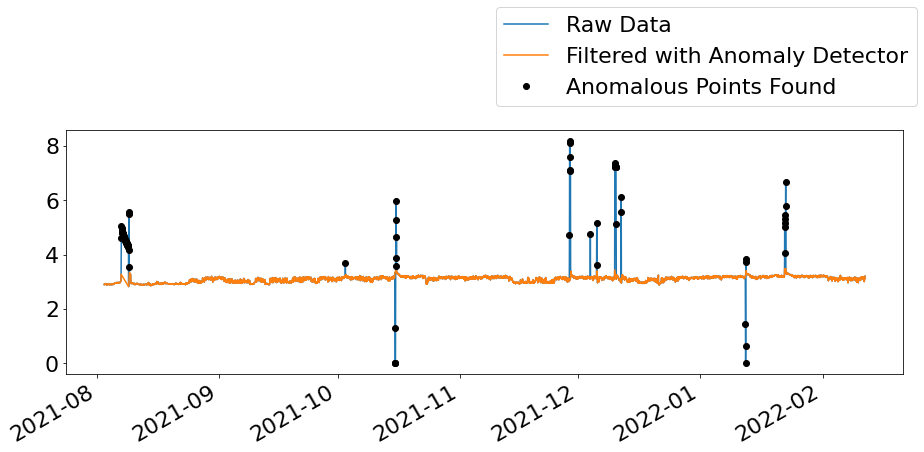

In [54]:
mask = anomaly_detector(df)
df.plot(figsize=(15,5))
df[mask].plot()
df[np.invert(mask)].plot(style='ok')
plt.legend(['Raw Data','Filtered with Anomaly Detector', 'Anomalous Points Found'],bbox_to_anchor=(0.5, 1.05))
#plt.savefig('results_2.png', bbox_inches='tight', dpi=1000)

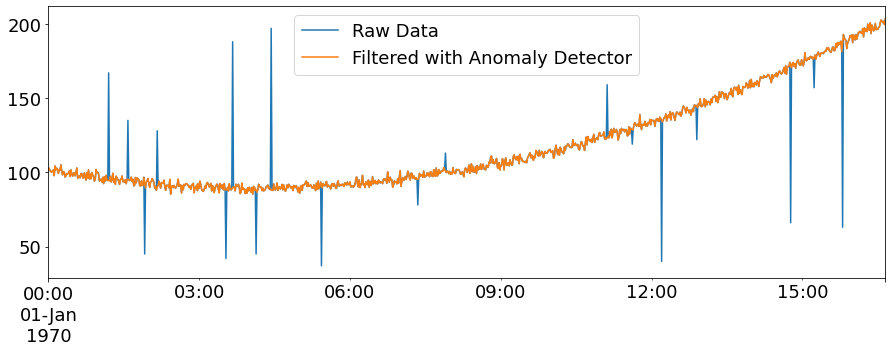

In [27]:
"""
=============
Extreme Outliers Removal
=============
Description of the example and what feature of the algorithm I'm showing off.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from indsl.data_quality import extreme

rng = np.random.default_rng(12345)
plt.rcParams.update({'font.size': 18})


# Create Toy clean dataset
nx = 1000
index = pd.date_range(start="1970", periods=nx, freq="1T")
x = np.linspace(0, 10, nx)
signal =  2*x**2- 10* x + 2
noise = np.random.normal(loc=100, size=nx, scale=2)
y = noise + signal

# Add anomalies
anom_num = rng.integers(low=0, high=200, size=20)
anom_ids = rng.integers(low=0, high=nx, size=20)
y[anom_ids] = anom_num
is_anom = [item in anom_ids for item in range(nx)]
raw_data = pd.Series(y, index = index)


# Find anomalies and plot results
res = extreme(raw_data)
res_2 = extreme(raw_data,bc_relaxation=2)

plt.figure(1, figsize=[15, 5])
raw_data.plot()
res.plot()

plt.legend(['Raw Data','Filtered with Anomaly Detector']);


In [64]:
# Copyright 2021 Cognite AS
import numpy as np
import pandas as pd

from scipy.stats import t as student_dist

def extreme(data: pd.Series, alpha: float = 0.05, bc_relaxation: float = 0.167, poly_order: int = 3):
    """Extreme outliers removal

    Outlier detector and removal based on the `paper from Gustavo A. Zarruk
    <https://iopscience.iop.org/article/10.1088/0957-0233/16/10/012/meta>`_. The procedure is as follows:

         * Fit a polynomial curve to the model using all of the data
         * Calculate the studentized deleted (or externally studentized) residuals
         * These residuals follow a t distribution with degrees of freedom n - p - 1
         * Bonferroni critical value can be computed using the significance level (alpha) and t distribution
         * Any values that fall outside of the critical value are treated as anomalies

    Use of the hat matrix diagonal allows for the rapid calculation of deleted residuals without having to refit
    the predictor function each time.

    Args:
        data (pandas.Series): Time series.
        alpha (float, optional): Significance level.
        bc_relaxation (float, optional): Factor.
            Relaxation factor for the Bonferroni critical value. Smaller values will make anomaly detection more
            conservative. Defaults to 1
        poly_order (int, optional): Polynomial order.
            Order of the polynomial used for the regression function

    Returns:
        pandas.Series: Time series without outliers.

    Raises:
        UserValueError: Alpha needs to be betwen 0 and 1
    """

    # Check inputs
    data = data.dropna()
    if len(data) < 3:
        raise RuntimeError(f"Not enough data (got {len(data)} values) to perform operation (min 3 values required!)")

    if not 0 < alpha < 1:
        raise UserValueError("Alpha needs to be a float between 0 and 1")

    # Convert datetime index to integers
    x = (np.array(data.index, dtype=np.int64) - data.index[0].value) / 1e9
    y = data.to_numpy()  # Just to please pandas devs

    # Create a polynomial fit and apply the fit to data
    coefs = np.polyfit(x, y, poly_order)
    y_pred = np.polyval(coefs, x)

    # Calculate hat matrix
    X_mat = np.vstack((np.ones_like(x), x)).T
    X_hat = X_mat @ np.linalg.inv(X_mat.T @ X_mat) @ X_mat.T
    hat_diagonal = X_hat.diagonal()

    # Calculate degrees of freedom
    n = len(y)
    dof = n - 3  # Using p = 2 from paper

    # Determine the residuals and standardise them
    res = y - y_pred
    sse = np.sum(res ** 2)
    t_res = res * np.sqrt(dof / (sse * (1 - hat_diagonal) - res))

    # Return p values from Student distribution and calculate Bonferroni critical value
    bc = student_dist.ppf(1 - alpha / (2 * n), df=dof) * bc_relaxation

    # Return filtered dataframe with the anomalies removed
    mask = np.logical_and(t_res < bc, t_res > - bc)
    return pd.Series(y[mask], index=data.index[mask])


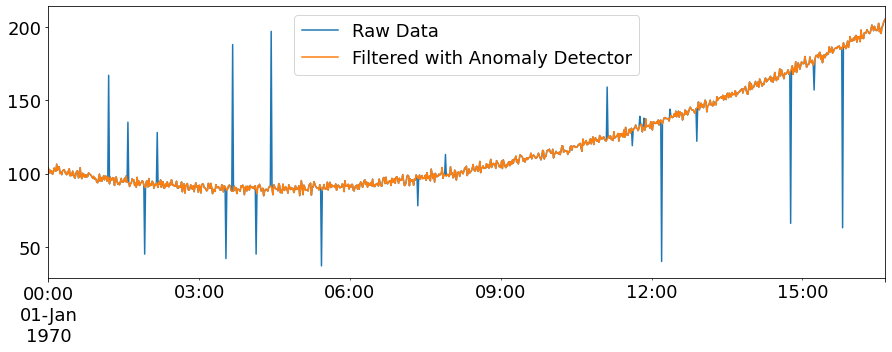

In [65]:
"""
=============
Extreme Outliers Removal
=============
Description of the example and what feature of the algorithm I'm showing off.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(12345)
plt.rcParams.update({'font.size': 18})


# Create Toy clean dataset
nx = 1000
index = pd.date_range(start="1970", periods=nx, freq="1T")
x = np.linspace(0, 10, nx)
signal =  2*x**2- 10* x + 2
noise = np.random.normal(loc=100, size=nx, scale=2)
y = noise + signal

# Add anomalies
anom_num = rng.integers(low=0, high=200, size=20)
anom_ids = rng.integers(low=0, high=nx, size=20)
y[anom_ids] = anom_num
is_anom = [item in anom_ids for item in range(nx)]
raw_data = pd.Series(y, index = index)


# Find anomalies and plot results
res = extreme(raw_data)
res_2 = extreme(raw_data,bc_relaxation=2)

plt.figure(1, figsize=[15, 5])
raw_data.plot()
res.plot()

plt.legend(['Raw Data','Filtered with Anomaly Detector']);